https://zhuanlan.zhihu.com/p/535036122 视频理解/动作分类 模型汇总


https://blog.csdn.net/weixin_43229348/article/details/118788119  Pytorch基础知识（14）基于PyTorch的视频分类

https://github.com/SwinTransformer/Video-Swin-Transformer

https://github.com/opengvlab/internvideo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training Dataset

In [ ]:
import cv2   #捕获视频库
import math  #数学操作库
import matplotlib.pyplot as plt   #画图的库
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # 预处理图像库
import numpy as np    #数学操作库

from skimage.transform import resize #改变图像尺寸
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

In [ ]:
# 导入训练集txt文件，里面有视频名字列表
f = open("/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/dsaa5002_2023fall_final_datasets/Data_Q3/tarin_tag.txt", "r")
temp = f.readlines()  # 逐行读取文件内容，并存储为列表

videos = []
labels = []

for line in temp:
    video, label = line.strip().split(',')
    videos.append(video)
    labels.append(int(label))

f.close()

# 创建含有视频名字列表的dataframe
train = pd.DataFrame()
train['video_name'] = videos


In [ ]:
print(train.tail(1))

         video_name
2062  305624414.mp4


In [ ]:
train['tag'] = labels

In [ ]:
train.head()

,video_name,tag
0,873879927.mp4,3
1,872438072.mp4,3
2,796902701_219_229.mp4,7
3,829923135_39_49.mp4,7
4,859022208.mp4,3


In [ ]:
import os

# 存储训练集视频的帧
for i in tqdm(range(train.shape[0])):
    count = 0
    videoFile = train['video_name'][i]
    video_tag = train['tag'][i]
    cap = cv2.VideoCapture('/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/dsaa5002_2023fall_final_datasets/Data_Q3/train_video/' + videoFile)   # 从给定路径获取视频

    frameRate = cap.get(5) #帧率
    x = 1

    while(cap.isOpened()):
        frameId = cap.get(1) #当前帧编号
        ret, frame = cap.read()
        if not ret:

            break
        if frameId % math.floor(frameRate) == 0:
            # 创建目标文件夹
            save_folder = '/content/train_1/'
            os.makedirs(save_folder, exist_ok=True)
            # 构建目标文件路径
            filename = os.path.join(save_folder, '{}_{}-frame{}.jpg'.format(video_tag, videoFile, count))

            # 保存帧图像
            cv2.imwrite(filename, frame)

            count += 1
    cap.release()

 36%|███▌      | 734/2063 [14:58<23:51,  1.08s/it]

In [ ]:
# 获取所有图像的名字
images = glob("/content/train_1/*.jpg")
train_image = []
train_class = []

In [ ]:
images[0]

'/content/train_1/11_649244905.mp4-frame22.jpg'

In [ ]:

for i in tqdm(range(len(images))):
    # 创建图像名


    train_image.append(images[i].split('/')[3])
    # 创建图像类标
    train_class.append(images[i].split('/')[3].split('_')[0])

# 存储在dataframe里
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# 转换dataframe为csv文件
train_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/Q3/train_image.csv',header=True, index=False)

100%|██████████| 26872/26872 [00:00<00:00, 636297.79it/s]


# Model

In [ ]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
from PIL import Image

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/Q3/train_image.csv')
train.head()

,image,class
0,11_649244905.mp4-frame22.jpg,11
1,7_691667686_145_155.mp4-frame4.jpg,7
2,9_514473425.mp4-frame9.jpg,9
3,11_887942863.mp4-frame9.jpg,11
4,2_871273898_87_97.mp4-frame0.jpg,2


In [ ]:
del image

In [ ]:
# 创建空列表
train_image = []

# 循环读取和保存帧
for i in tqdm(range(train.shape[0])):
     # 载入图片
    img = Image.open('/content/train_1/' + train['image'][i])
    # 调整大小
    img = img.resize((224, 224))
    # 转换为array
    img = np.array(img)
    # 保存到train_image列表
    train_image.append(img)

# 转换为numpy数组
X = np.array(train_image)

# 输出形状
X.shape

100%|██████████| 26872/26872 [03:25<00:00, 130.91it/s]


(26872, 224, 224, 3)

In [ ]:
# 分离数据集
y = train['class']

# 创建训练与测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [ ]:
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

In [ ]:
# 创建预训练的VGG16基本模型
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# 从训练集的帧中提取特征
X_train = base_model.predict(X_train)

# 从验证集的帧中提取特征
X_val = base_model.predict(X_val)
X_val.shape

168/168 [==============================] - 25s 149ms/step


(5375, 7, 7, 512)

In [ ]:
X_train.shape

(21497, 7, 7, 512)

In [ ]:
X_train = X_train.reshape(21497, 7*7*512)
X_val = X_val.reshape(5375, 7*7*512)

In [ ]:
# 标准化像素值
max = X_train.max()
X_train = X_train/max
X_val = X_val/max

In [ ]:
# 图像形状
X_train.shape

(21497, 25088)

In [ ]:
#定义结构
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

In [ ]:
# 保存权重函数
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/Q3/weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# 编译模型
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

Epoch 1/50
166/168 [============================>.] - ETA: 0s - loss: 2.0979 - accuracy: 0.3110

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/168 [==============================] - 10s 35ms/step - loss: 2.0882 - accuracy: 0.3140 - val_loss: 0.8988 - val_accuracy: 0.7254
Epoch 2/50
168/168 [==============================] - 4s 24ms/step - loss: 0.8423 - accuracy: 0.7361 - val_loss: 0.3948 - val_accuracy: 0.8845
Epoch 3/50
168/168 [==============================] - 4s 24ms/step - loss: 0.4269 - accuracy: 0.8743 - val_loss: 0.2947 - val_accuracy: 0.9241
Epoch 4/50
168/168 [==============================] - 4s 25ms/step - loss: 0.2853 - accuracy: 0.9221 - val_loss: 0.2554 - val_accuracy: 0.9362
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2006 - accuracy: 0.9473 - val_loss: 0.2962 - val_accuracy: 0.9356
Epoch 6/50
168/168 [==============================] - 4s 24ms/step - loss: 0.1614 - accuracy: 0.9592 - val_loss: 0.2538 - val_accuracy: 0.9475
Epoch 7/50
168/168 [==============================] - 3s 18ms/step - loss: 0.1409 - accuracy: 0.9655 - val_loss: 0.2728 - val_accuracy: 0.9427
Epoch 8/5

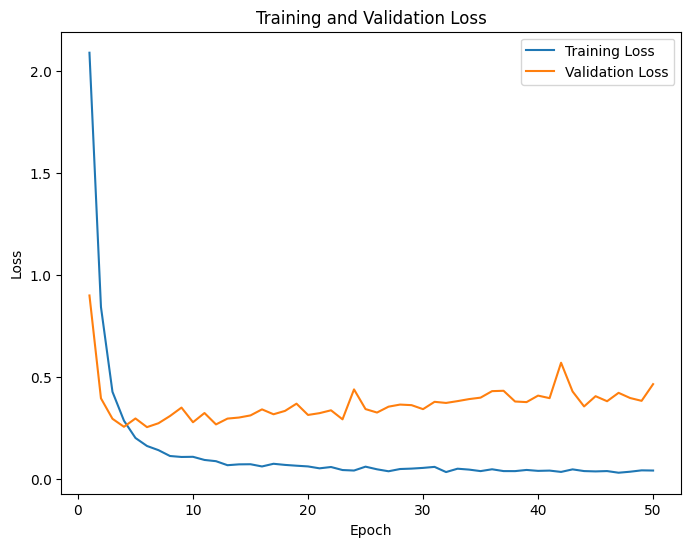

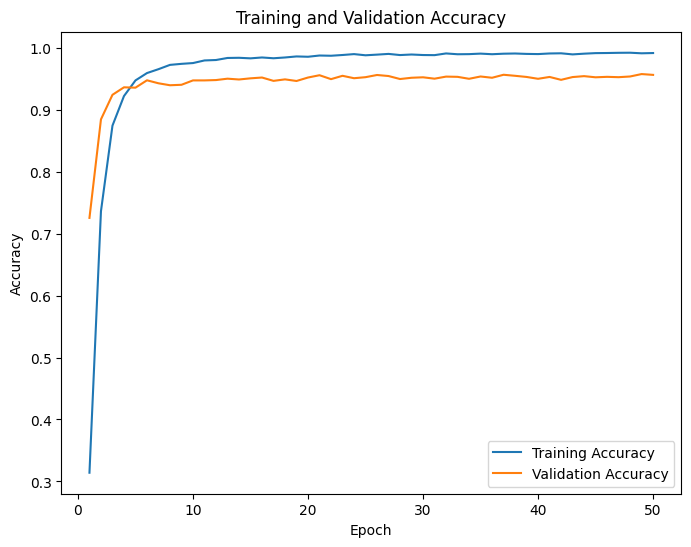

Training Accuracy: 0.9915336966514587
Validation Accuracy: 0.9562790989875793


In [ ]:
# 训练模型
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[mcp_save], batch_size=128)

# 获取训练过程中的损失和准确度
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']



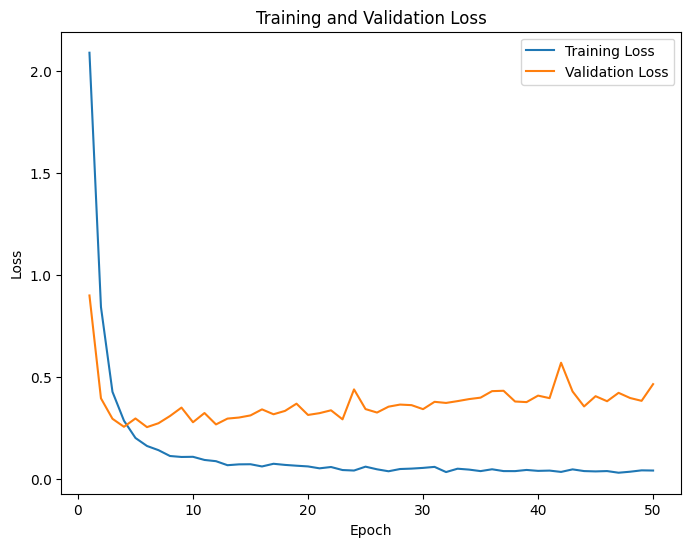

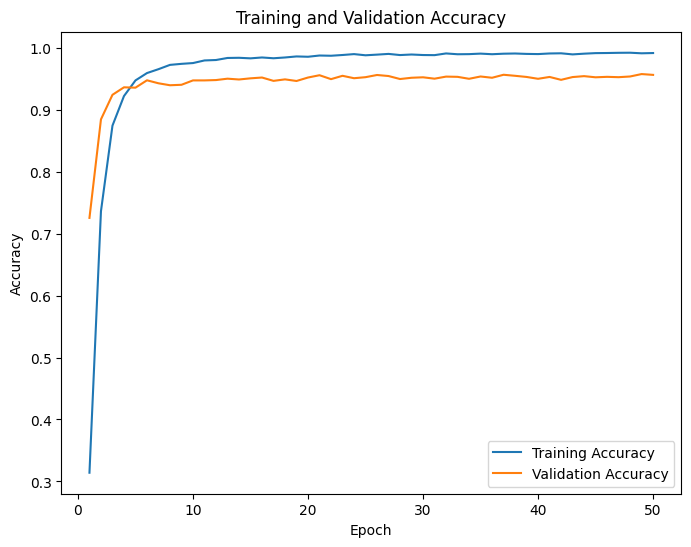

In [ ]:
# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 绘制准确度曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



In [ ]:
# 打印最后一个训练周期的精度
print('Training Accuracy:', train_accuracy[-1])
print('Validation Accuracy:', val_accuracy[-1])

Training Accuracy: 0.9915336966514587
Validation Accuracy: 0.9562790989875793


# Predict the model

In [ ]:
from scipy import stats

In [ ]:
y = train['class']
y = pd.get_dummies(y)

In [ ]:
y.columns.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
predict = []
file_names = []
path = '/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/dsaa5002_2023fall_final_datasets/Data_Q3/test_video/'

# 循环处理每个测试视频
for filename in tqdm(os.listdir(path)):
    if filename.endswith(".mp4"):
        file_names.append(filename)
        cap = cv2.VideoCapture(os.path.join(path, filename))  # 从给定路径获取视频
        frameRate = cap.get(cv2.CAP_PROP_FPS)  # 帧率


        count = 0  # 帧计数器
        frame_interval = 5  # 保存帧的间隔
        while cap.isOpened():
            frameId = cap.get(cv2.CAP_PROP_POS_FRAMES)  # 当前帧编号
            ret, frame = cap.read()
            if not ret:
                break
            if frameId % frame_interval == 0:
                # 创建目标文件夹
                save_folder = '/content/tem/'
                os.makedirs(save_folder, exist_ok=True)
                frame_filename = os.path.splitext(filename)[0]
                save_filename = os.path.join('/content/tem/', '{}-frame{}.jpg'.format(frame_filename, count))

                cv2.imwrite(save_filename, frame)
                #print(save_filename)
                count += 1




        cap.release()

        # 对提取的帧进行预测
        prediction_images = []
        for i in range(0, count):
            img_path = os.path.join('/content/tem/', '{}-frame{}.jpg'.format(frame_filename, i))
            img = image.load_img(img_path, target_size=(224, 224, 3))
            img = image.img_to_array(img)
            img = img / 255
            prediction_images.append(img)

        # 将测试视频的所有帧转换为numpy数组
        prediction_images = np.array(prediction_images)

        # 提取特征
        prediction_images = base_model.predict(prediction_images)
        prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)

        # 预测
        prediction = model.predict(prediction_images)
        #print(prediction)
        # 获取每帧视频最大概率对应的类别索引
        max_indices = np.argmax(prediction, axis=1)

        # 获取类别标签
        labels = y.columns.values[max_indices]

        # 对每个视频的类别标签取众数
        video_labels = stats.mode(labels)[0]

        # 打印最终视频预测标签
        print(video_labels)

        # 添加预测结果的标签到 predict 列表中
        predict.append(video_labels)



In [ ]:
prediction = np.array([[8.95534135e-13, 3.27184670e-14, 4.80630218e-17, 1.46180512e-09,
                        1.69841558e-14, 2.21222009e-15, 9.99376357e-01, 3.51033923e-05,
                        3.56076366e-12, 8.80777385e-14, 5.88583353e-04, 2.33640690e-10,
                        4.79961071e-11, 8.32809231e-15, 5.21753534e-15],
                       [8.27825818e-13, 2.59594033e-14, 4.08488455e-17, 1.40548184e-09,
                        1.61725119e-14, 1.86271524e-15, 9.99469221e-01, 3.86640495e-05,
                        3.38755629e-12, 7.80347399e-14, 4.92105144e-04, 2.04426892e-10,
                        4.62368581e-11, 7.36209698e-15, 5.28234860e-15]])
max_indices = np.argmax(prediction, axis=1)
print(max_indices)

[6 6]


In [ ]:
result_df=pd.DataFrame()
result_df['file_name'] = file_names
result_df['label'] = predict
result_df.head(10)



In [ ]:
result_df['label'].value_counts()

In [ ]:
result_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/5002/DSAA5002_50015756_Gelin_Bian_final/Q3/Q3_output.csv',index=False)